In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# データ拡張
class SimCLRTransform:
    def __init__(self, size=32):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])
    def __call__(self, x):
        return self.transform(x), self.transform(x)

# シンプルなエンコーダ＋投影ヘッド
class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super().__init__()
        self.encoder = getattr(models, base_model)(pretrained=False)
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.Linear(num_ftrs, out_dim)
        )
    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

# NT-Xent損失
def nt_xent_loss(z1, z2, temperature=0.5):
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # [2N, D]
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2N, 2N]
    sim = sim / temperature

    # マスクを作成（自分自身との類似度を除外）
    mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    # 正例ペアのインデックスを作成
    pos_indices = (torch.arange(N, device=z.device) + N) % (2*N)
    labels = torch.cat([pos_indices, torch.arange(N, device=z.device)])

    # 各サンプルごとに正例ペアの位置をlabelsとして指定
    loss = 0
    for i in range(2*N):
        # i番目のサンプルの正例ペアのインデックス
        if i < N:
            pos_idx = i + N
        else:
            pos_idx = i - N
        logits = sim[i]
        loss += F.cross_entropy(logits.unsqueeze(0), torch.tensor([pos_idx], device=z.device))
    loss = loss / (2*N)
    return loss

# データセットとデータローダ
transform = SimCLRTransform()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, drop_last=True)

# モデル・最適化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [4]:
import tqdm

# 学習ループ（1エポック例）
model.train()
for (x1, x2), _ in tqdm.tqdm(train_loader):
    x1, x2 = x1.to(device), x2.to(device)
    z1 = model(x1)
    z2 = model(x2)
    loss = nt_xent_loss(z1, z2, temperature=0.3)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Loss: {loss.item():.4f}')
    # break  # サンプルとして1バッチのみ

  0%|          | 0/97 [00:00<?, ?it/s]

  1%|          | 1/97 [00:33<53:06, 33.19s/it]

Loss: 6.8594


  2%|▏         | 2/97 [00:55<42:40, 26.95s/it]

Loss: 6.8394


  3%|▎         | 3/97 [01:15<37:07, 23.70s/it]

Loss: 6.7388


  4%|▍         | 4/97 [01:35<34:40, 22.37s/it]

Loss: 6.5993


  5%|▌         | 5/97 [01:55<32:50, 21.42s/it]

Loss: 6.5486


  6%|▌         | 6/97 [02:15<31:47, 20.96s/it]

Loss: 6.4910


  7%|▋         | 7/97 [02:35<30:40, 20.45s/it]

Loss: 6.4179


  8%|▊         | 8/97 [02:56<30:42, 20.70s/it]

Loss: 6.4248


  9%|▉         | 9/97 [03:18<31:09, 21.24s/it]

Loss: 6.3507


 10%|█         | 10/97 [03:38<30:01, 20.71s/it]

Loss: 6.3793


 11%|█▏        | 11/97 [04:00<30:18, 21.14s/it]

Loss: 6.2071


 12%|█▏        | 12/97 [04:24<31:09, 22.00s/it]

Loss: 6.2985


 13%|█▎        | 13/97 [04:49<32:10, 22.98s/it]

Loss: 6.2662


 14%|█▍        | 14/97 [05:19<34:37, 25.03s/it]

Loss: 6.1861


 15%|█▌        | 15/97 [05:48<35:41, 26.11s/it]

Loss: 6.2770


 16%|█▋        | 16/97 [06:24<39:19, 29.13s/it]

Loss: 6.2046


 18%|█▊        | 17/97 [06:51<38:10, 28.63s/it]

Loss: 6.1084


 19%|█▊        | 18/97 [07:17<36:25, 27.66s/it]

Loss: 6.1309


 20%|█▉        | 19/97 [07:39<34:03, 26.19s/it]

Loss: 6.0721


 21%|██        | 20/97 [08:00<31:23, 24.46s/it]

Loss: 6.0969


 22%|██▏       | 21/97 [08:20<29:21, 23.18s/it]

Loss: 6.1534


 23%|██▎       | 22/97 [08:41<28:14, 22.59s/it]

Loss: 6.0970


 24%|██▎       | 23/97 [09:01<26:51, 21.77s/it]

Loss: 6.0732


 25%|██▍       | 24/97 [09:22<26:22, 21.67s/it]

Loss: 6.0962


 26%|██▌       | 25/97 [09:54<29:24, 24.51s/it]

Loss: 6.1706


 27%|██▋       | 26/97 [10:15<27:53, 23.57s/it]

Loss: 6.0182


 28%|██▊       | 27/97 [10:37<26:55, 23.08s/it]

Loss: 6.0192


 29%|██▉       | 28/97 [10:59<26:05, 22.68s/it]

Loss: 6.0608


 30%|██▉       | 29/97 [11:20<25:20, 22.36s/it]

Loss: 6.0077


 31%|███       | 30/97 [11:44<25:21, 22.71s/it]

Loss: 5.9294


 32%|███▏      | 31/97 [12:07<24:59, 22.73s/it]

Loss: 6.0710


 33%|███▎      | 32/97 [12:35<26:29, 24.45s/it]

Loss: 6.0009


 34%|███▍      | 33/97 [13:03<27:13, 25.53s/it]

Loss: 5.9707


 35%|███▌      | 34/97 [13:27<26:22, 25.11s/it]

Loss: 5.9715


 36%|███▌      | 35/97 [13:50<25:10, 24.36s/it]

Loss: 5.9822


 37%|███▋      | 36/97 [14:11<23:49, 23.44s/it]

Loss: 5.9201


 38%|███▊      | 37/97 [14:35<23:30, 23.51s/it]

Loss: 5.9759


 39%|███▉      | 38/97 [15:00<23:34, 23.98s/it]

Loss: 5.9758


 40%|████      | 39/97 [15:24<23:07, 23.92s/it]

Loss: 5.9599


 41%|████      | 40/97 [15:48<22:43, 23.93s/it]

Loss: 5.9759


 42%|████▏     | 41/97 [16:13<22:50, 24.48s/it]

Loss: 5.9818


 43%|████▎     | 42/97 [16:38<22:31, 24.57s/it]

Loss: 5.8674


 44%|████▍     | 43/97 [17:01<21:38, 24.05s/it]

Loss: 6.0283


 45%|████▌     | 44/97 [17:25<21:21, 24.19s/it]

Loss: 5.9239


 46%|████▋     | 45/97 [17:51<21:19, 24.60s/it]

Loss: 6.0090


 47%|████▋     | 46/97 [18:14<20:25, 24.04s/it]

Loss: 5.9388


 48%|████▊     | 47/97 [18:46<22:04, 26.48s/it]

Loss: 5.9993


 49%|████▉     | 48/97 [19:15<22:17, 27.30s/it]

Loss: 5.9314


 51%|█████     | 49/97 [19:52<24:11, 30.24s/it]

Loss: 5.9038


 52%|█████▏    | 50/97 [20:24<24:03, 30.71s/it]

Loss: 5.8022


 53%|█████▎    | 51/97 [21:41<34:13, 44.65s/it]

Loss: 5.9768


 54%|█████▎    | 52/97 [22:07<29:19, 39.10s/it]

Loss: 5.8211


 55%|█████▍    | 53/97 [22:32<25:36, 34.91s/it]

Loss: 5.9542


 56%|█████▌    | 54/97 [22:54<22:04, 30.79s/it]

Loss: 5.9360


 57%|█████▋    | 55/97 [23:13<19:14, 27.48s/it]

Loss: 5.7991


 58%|█████▊    | 56/97 [23:34<17:21, 25.41s/it]

Loss: 5.9714


 59%|█████▉    | 57/97 [23:55<16:05, 24.13s/it]

Loss: 5.8575


 60%|█████▉    | 58/97 [24:15<14:48, 22.78s/it]

Loss: 5.8413


 61%|██████    | 59/97 [24:35<13:56, 22.02s/it]

Loss: 6.0003


 62%|██████▏   | 60/97 [24:55<13:13, 21.46s/it]

Loss: 5.9217


 63%|██████▎   | 61/97 [25:16<12:45, 21.27s/it]

Loss: 5.9234


 64%|██████▍   | 62/97 [25:36<12:08, 20.80s/it]

Loss: 5.9319


 65%|██████▍   | 63/97 [25:56<11:38, 20.54s/it]

Loss: 5.8287


 66%|██████▌   | 64/97 [26:16<11:13, 20.41s/it]

Loss: 5.9332


 67%|██████▋   | 65/97 [26:35<10:46, 20.21s/it]

Loss: 5.7736


 68%|██████▊   | 66/97 [26:56<10:30, 20.34s/it]

Loss: 5.8739


 69%|██████▉   | 67/97 [27:16<10:01, 20.06s/it]

Loss: 5.8895


 70%|███████   | 68/97 [27:36<09:47, 20.25s/it]

Loss: 5.9665


 71%|███████   | 69/97 [27:57<09:30, 20.36s/it]

Loss: 5.8473


 72%|███████▏  | 70/97 [28:16<09:01, 20.07s/it]

Loss: 5.9463


 73%|███████▎  | 71/97 [28:36<08:40, 20.02s/it]

Loss: 5.8703


 74%|███████▍  | 72/97 [28:56<08:17, 19.89s/it]

Loss: 5.8370


 75%|███████▌  | 73/97 [29:16<08:03, 20.13s/it]

Loss: 5.8467


 76%|███████▋  | 74/97 [29:36<07:41, 20.06s/it]

Loss: 5.8274


 77%|███████▋  | 75/97 [29:56<07:19, 19.98s/it]

Loss: 5.8473


 78%|███████▊  | 76/97 [30:16<07:01, 20.07s/it]

Loss: 5.8968


 79%|███████▉  | 77/97 [30:36<06:39, 20.00s/it]

Loss: 5.8239


 80%|████████  | 78/97 [30:55<06:14, 19.70s/it]

Loss: 5.8075


 81%|████████▏ | 79/97 [31:16<06:02, 20.16s/it]

Loss: 5.7399


 82%|████████▏ | 80/97 [31:37<05:43, 20.23s/it]

Loss: 5.8291


 84%|████████▎ | 81/97 [31:57<05:22, 20.18s/it]

Loss: 5.7391


 85%|████████▍ | 82/97 [32:17<05:00, 20.03s/it]

Loss: 5.8009


 86%|████████▌ | 83/97 [32:37<04:40, 20.06s/it]

Loss: 5.7636


 87%|████████▋ | 84/97 [32:58<04:24, 20.38s/it]

Loss: 5.7696


 88%|████████▊ | 85/97 [33:18<04:03, 20.33s/it]

Loss: 5.7154


 89%|████████▊ | 86/97 [33:40<03:48, 20.73s/it]

Loss: 5.7888


 90%|████████▉ | 87/97 [34:01<03:28, 20.85s/it]

Loss: 5.7372


 91%|█████████ | 88/97 [34:21<03:06, 20.76s/it]

Loss: 5.8839


 92%|█████████▏| 89/97 [34:42<02:46, 20.78s/it]

Loss: 5.8042


 93%|█████████▎| 90/97 [35:02<02:22, 20.34s/it]

Loss: 5.7774


 94%|█████████▍| 91/97 [35:21<02:00, 20.13s/it]

Loss: 5.7910


 95%|█████████▍| 92/97 [35:41<01:40, 20.07s/it]

Loss: 5.8676


 96%|█████████▌| 93/97 [36:00<01:19, 19.82s/it]

Loss: 5.8394


 97%|█████████▋| 94/97 [36:22<01:00, 20.29s/it]

Loss: 5.8188


 98%|█████████▊| 95/97 [36:42<00:40, 20.16s/it]

Loss: 5.8064


 99%|█████████▉| 96/97 [37:02<00:20, 20.11s/it]

Loss: 5.7953


100%|██████████| 97/97 [37:21<00:00, 19.95s/it]

Loss: 5.7995


100%|██████████| 97/97 [37:22<00:00, 23.12s/it]



In [6]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. 特徴抽出用データセット（データ拡張なし）
eval_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_set = datasets.CIFAR10(root='./data', train=True, download=False, transform=eval_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=False, transform=eval_transform)
train_loader_eval = DataLoader(train_set, batch_size=256, shuffle=False, num_workers=2)
test_loader_eval = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# 2. エンコーダから特徴抽出
def extract_features(loader):
    model.eval()
    feats = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h = model.encoder(x)  # 投影ヘッドは使わない
            feats.append(h.cpu().numpy())
            labels.append(y.numpy())
    feats = np.concatenate(feats)
    labels = np.concatenate(labels)
    return feats, labels

train_feats, train_labels = extract_features(train_loader_eval)
test_feats, test_labels = extract_features(test_loader_eval)

# 3. ロジスティック回帰で分類
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
clf.fit(train_feats, train_labels)
preds = clf.predict(test_feats)
acc = accuracy_score(test_labels, preds)
print(f"Test accuracy: {acc:.4f}")

/home/ryutaro/workspace/simclr-test/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.4537


/home/ryutaro/workspace/simclr-test/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


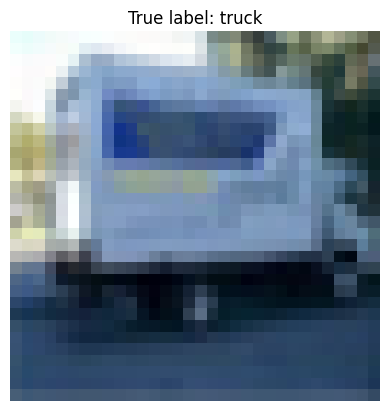

Predicted label: ship


In [16]:
import matplotlib.pyplot as plt
import random

# CIFAR-10のラベル名
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 1. データセットからランダムに画像1枚を取り出し、imshow
idx = random.randint(0, len(test_set) - 1)
img, label = test_set[idx]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"True label: {class_names[label]}")
plt.axis('off')
plt.show()

# 2. 画像に対してモデルを適用し、分類結果を出力
model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to(device)
    feat = model.encoder(x).cpu().numpy()
    pred = clf.predict(feat)[0]
    print(f"Predicted label: {class_names[pred]}")